In [1]:
%matplotlib notebook
import numpy as np
import pylab
import seaborn

c:\users\terry\py2\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [55]:
with file('retina-20170704-234348_flying1.dat', 'rb') as f:
    data = f.read()

data = np.fromstring(data, np.uint8)
print len(data)

packet_size = 6

t = data[2::packet_size].astype(np.uint32)
t = (t << 8) + data[3::packet_size]
if packet_size >= 5:
    t = (t << 8) + data[4::packet_size]
if packet_size >=6:
    t = (t << 8) + data[5::packet_size]
    
y = data[::packet_size] & 0x7F
x = data[1::packet_size] & 0x7F
p = data[1::packet_size] >= 0x80

2805852


In [64]:
ignore_repeats = False


last_on = np.zeros((128, 128), np.uint32)
last_off = np.zeros((128, 128), np.uint32)
freq = np.zeros((128, 128), np.float32)
image = np.zeros((128, 128), np.float32)

freq_slices = []
image_slices = []
slice_period = 0.1
last_slice_time = 0

target_freq = 100.0
sigma_freq = 10.0

s = np.zeros(len(t), np.float32)
f = np.zeros(len(t), np.float32)

count = 0
for i, tt in enumerate(t):
    xx = x[i]
    yy = y[i]
    pp = p[i]
    
    image[xx, yy] += 1 if pp else -1
    
    if tt > last_slice_time + slice_period * 1000000:
        freq_slices.append(freq.copy())
        image_slices.append(image.copy())
        image *= 0.5
        last_slice_time = tt
        
    
    if ignore_repeats:
        if pp and last_on[xx, yy] > last_off[xx, yy]:
            continue
        if not pp and last_off[xx, yy] > last_on[xx, yy]:
            continue
            
    if pp:
        half_period = tt - last_off[xx, yy]
    else:
        half_period = tt - last_on[xx, yy]
        
    ff = 500000.0 / half_period
    
    freq[xx, yy] = ff
    f[i] = ff
    
    score = np.exp(-((ff-target_freq)**2)/(2*sigma_freq**2))
    s[i] = score
            
    if pp:
        last_on[xx, yy] = tt
    else:
        last_off[xx, yy] = tt    
    count += 1
    
    
    
print(count)

467642


In [65]:
np.max(s)

0.99999797

In [66]:
np.max(f)

500000.0

<IPython.core.display.Javascript object>


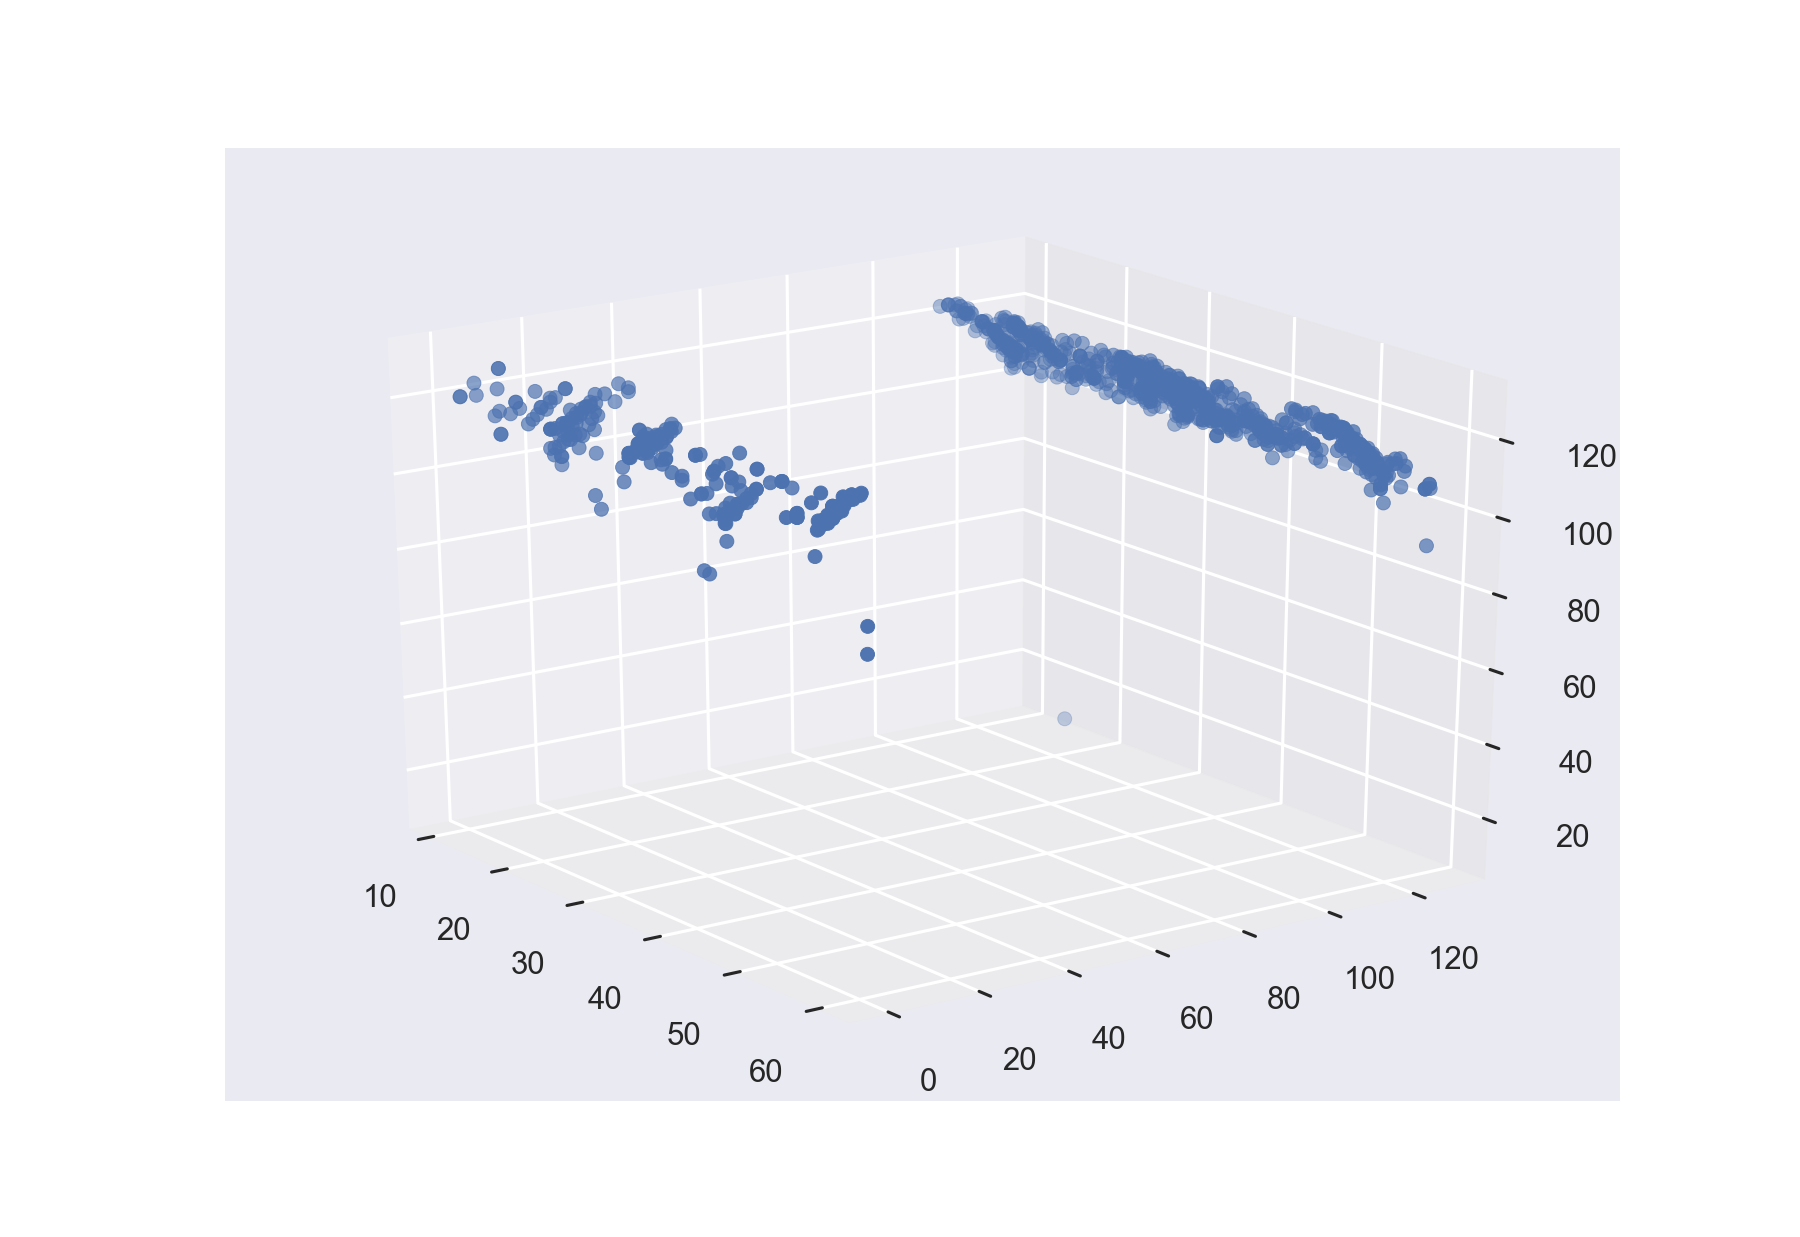

In [67]:
from mpl_toolkits.mplot3d import Axes3D

fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
N = 100

indices = np.where(s>0.1)[0]

ax.scatter((t[indices]-t[0])/1000000.0, x[indices], y[indices])


In [68]:
len(freq_slices)

553

<IPython.core.display.Javascript object>


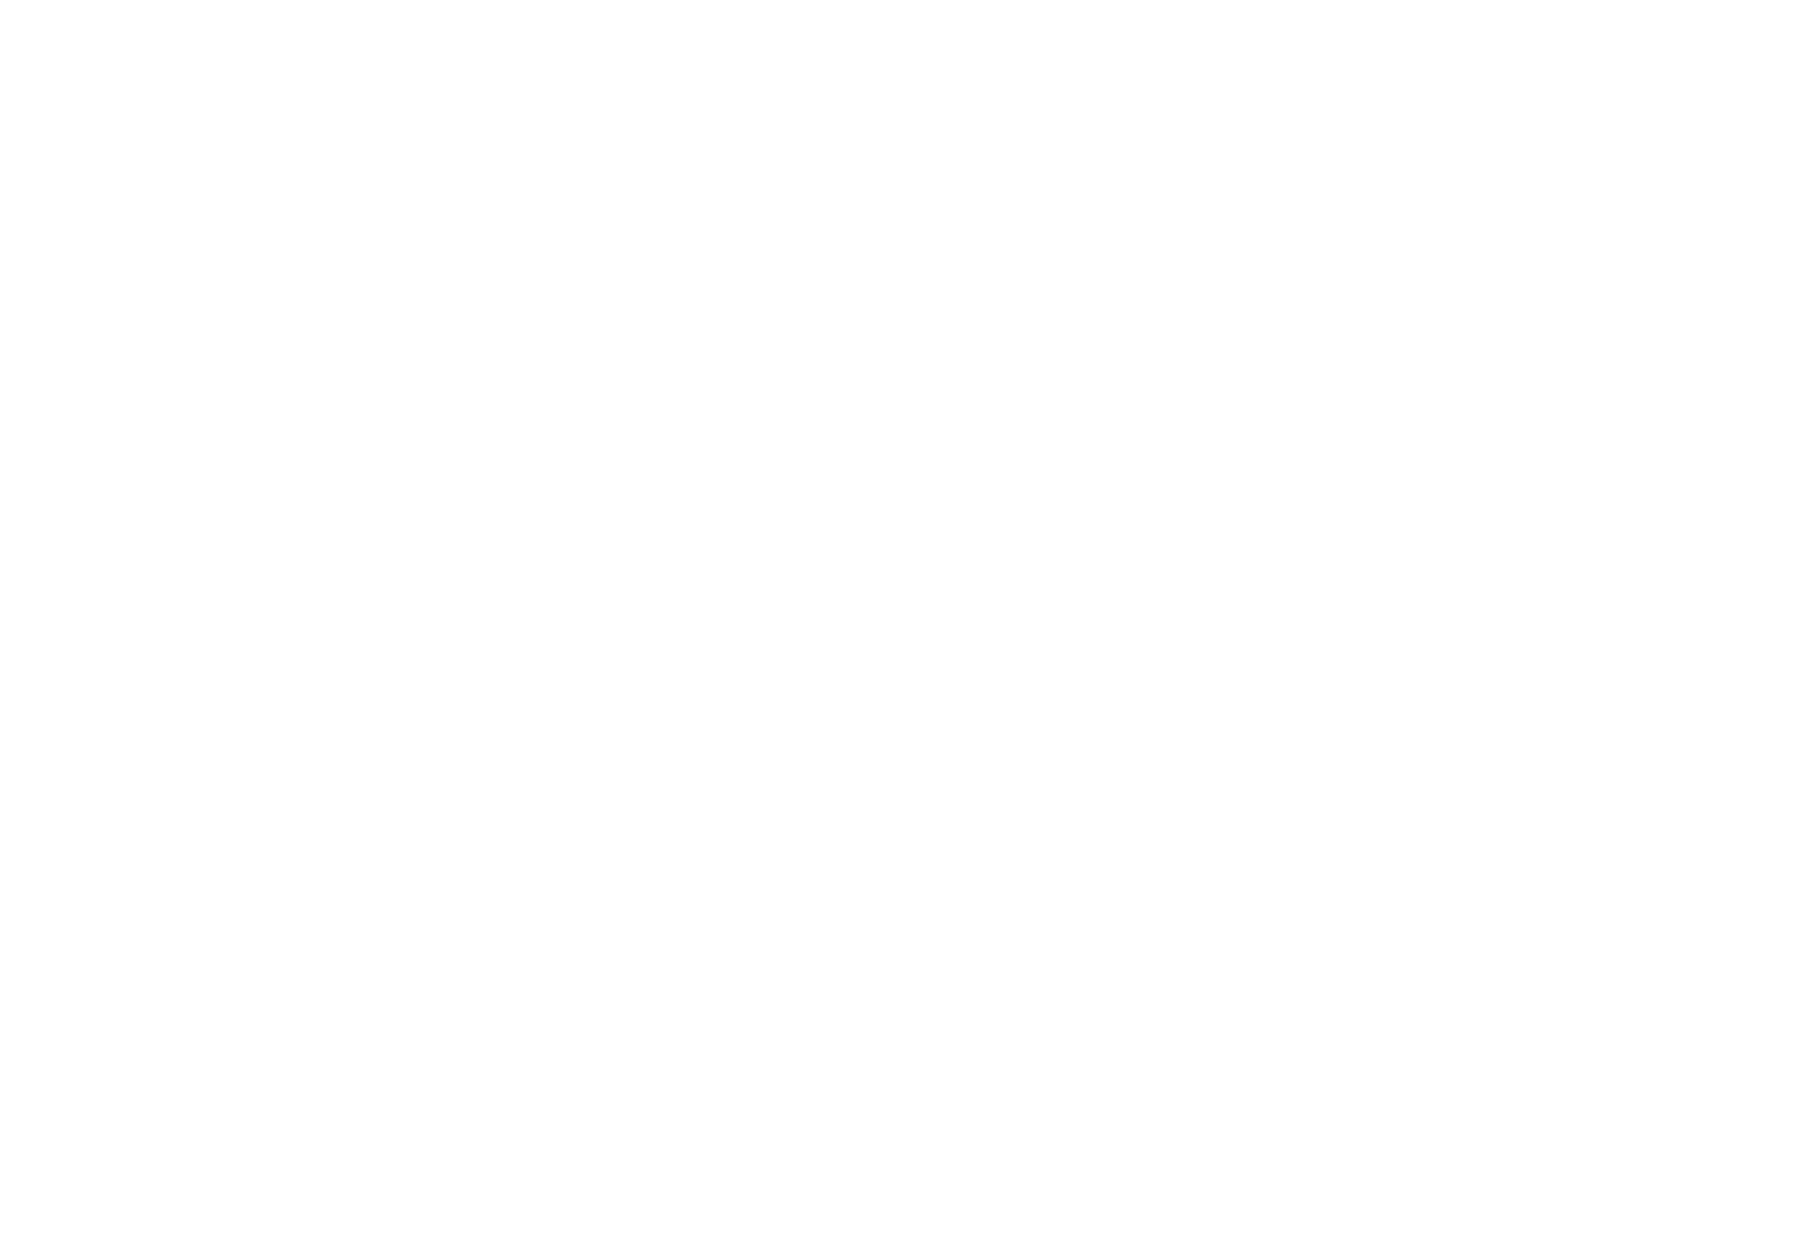

In [74]:
pylab.figure()
for i, fs in enumerate(freq_slices):
    if i % 10 != 0:
        continue
    pylab.subplot(1, 2, 1)
    pylab.imshow(image_slices[i], vmin=-1, vmax=1)
    
    pylab.subplot(1, 2, 2)
    pylab.imshow(fs, cmap='jet', vmin=0, vmax=10)#, vmin=0, vmax=np.max(freq_slices))
    pylab.colorbar()
    pylab.title('t = %g' % (i * slice_period))
    pylab.savefig('%04d.jpg' % i, dpi=300)
    pylab.clf()